<b>Collecting Marketing Dataset

In [1]:
import pandas as pd
train_df=pd.read_parquet('train_sample.parquet')
test_df=pd.read_parquet('test_sample.parquet')

In [2]:
train_df.sample(10)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
46095,22.640867,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
199280,24.909539,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
882948,12.616365,10.059654,8.435012,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,16.226044,5.300375,-0.168679,1,0,0,0
245212,26.192572,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
972403,22.543348,10.059654,8.913464,4.679882,10.280525,4.115453,-5.576414,4.833815,3.780649,13.190056,5.300375,-0.168679,1,0,0,0
470024,22.778342,10.059654,8.214383,4.679882,10.280525,4.115453,-8.058865,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
522091,21.284904,10.059654,8.214383,4.679882,10.280525,4.115453,-11.299958,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
128092,25.540311,10.059654,8.214383,4.679882,10.280525,4.115453,-11.589224,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
190200,25.774667,10.059654,8.214383,4.679882,10.280525,4.115453,-5.576414,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
346236,12.616365,10.059654,8.856511,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [3]:
feature_col=['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
treatement_col=['treatment']
outcome_col = ['conversion']
secondary_outcome_col = ['visit']
confounder_col=['exposure']

<b>Data preprocessing

No need as all are numerical data and dataset have no missing values


In [4]:
train_df.isna().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [5]:
test_df.dtypes

f0            float64
f1            float64
f2            float64
f3            float64
f4            float64
f5            float64
f6            float64
f7            float64
f8            float64
f9            float64
f10           float64
f11           float64
treatment       int64
conversion      int64
visit           int64
exposure        int64
dtype: object

<b>Randomized assignment</b>: treatment is random, both groups are statistically identical on average — so any difference in outcome is caused by the treatment, not by pre-existing differences. <br>
Difference in purchase rates = true causal effect (unbiased).<br>

<b>Biased assignment</b> : Suppose marketers target the ad to users who already look interested — maybe they visited the website before, or searched for similar products.<br>Now, treated users are systematically different (more likely to buy anyway).
If you compare treated vs. control : <br>Treated conversion rate = 100%
Control conversion rate = 0%

So you might wrongly think the ad caused a 100% increase,
but actually it’s because you targeted users who were already interested.

❌ This is confounding — a hidden variable (interest) affects both treatment and outcome.

This is what we call biased assignment or observational data.

In [6]:
# Now creating biased and randomized synthetic dataset
import numpy as np
import pandas as pd

np.random.seed(42)
n=100000 # No of rows in the dataset

# Generating anonymized features(f0-f11)
features=np.random.normal(0,10,size=(n,12))
features_col=[f'f{i}' for i in range(12)]

# Generating confounder(exposure)
exposure = 1/(1+np.exp(-0.2 * (features[:,0]+features[:,1])))

# Genearting treatement 
treatement_random=np.random.binomial(1,0.5,n)  # Randomized assignment

treatement_biased = np.random.binomial(1,exposure)   # Biased assignment


true_effect= 0.1 # True treatement effect <----- ****in real dataset i have to find this****

# Generating randomized outcome 
base_prob_random =1/(1+np.exp(-(0.05*features[:,2]+0.03*features[:,3])))
outcome_prob_random = base_prob_random * true_effect * treatement_random + np.random.normal(0,0.2,n)
outcome_random=(outcome_prob_random>0.5).astype(int)

# Generating biased outcome 
base_prob_biased =1/(1+np.exp(-(0.05*features[:,2]+0.03*features[:,3])))
outcome_prob_biased = base_prob_biased * true_effect * treatement_biased + np.random.normal(0,0.2,n)
outcome_biased=(outcome_prob_biased>0.5).astype(int)

# Genearting "visit" variable
visit_prob = 1 / (1 + np.exp(-0.05 * (features[:, 4] + 0.3 * exposure)))
visit_random = (visit_prob > 0.5).astype(int)
visit_biased = (visit_prob > 0.5).astype(int)

# Creating dataframes
df_random= pd.DataFrame(features,columns=features_col)
df_random['treatement']=treatement_random
df_random['conversion']=outcome_random
df_random['exposure'] = exposure
df_random['visit'] =visit_random

df_biased= pd.DataFrame(features,columns=features_col)
df_biased['treatement']=treatement_biased
df_biased['conversion']=outcome_biased
df_biased['exposure'] = exposure
df_biased['visit'] =visit_biased


print("Randomized A/B dataset:\n", df_random.head())
print("\nBiased dataset:\n", df_biased.head())

# save to CSV
df_random.to_csv("randomized_data.csv", index=False)
df_biased.to_csv("biased_data.csv", index=False)

Randomized A/B dataset:
          f0         f1         f2         f3         f4        f5         f6  \
0  4.967142  -1.382643   6.476885  15.230299  -2.341534 -2.341370  15.792128   
1  2.419623 -19.132802 -17.249178  -5.622875 -10.128311  3.142473  -9.080241   
2 -5.443827   1.109226 -11.509936   3.756980  -6.006387 -2.916937  -6.017066   
3  2.088636 -19.596701 -13.281860   1.968612   7.384666  1.713683  -1.156483   
4  3.436183 -17.630402   3.240840  -3.850823  -6.769220  6.116763  10.309995   

          f7         f8         f9       f10        f11  treatement  \
0   7.674347  -4.694744   5.425600 -4.634177  -4.657298           1   
1 -14.123037  14.656488  -2.257763  0.675282 -14.247482           1   
2  18.522782  -0.134972 -10.577109  8.225449 -12.208436           0   
3  -3.011037 -14.785220  -7.198442 -4.606388  10.571222           1   
4   9.312801  -8.392175  -3.092124  3.312634   9.755451           1   

   conversion  exposure  visit  
0           0  0.671924      0  
1

Making baseline model for true treatement effect estimation<br>
<b>Naive estimator </b> : It assumes the treatment was assigned randomly (like an ideal A/B test), even if in reality it wasn’t.<br>
Naiveve ATE=E[Y∣T=1]−E[Y∣T=0]
<br>
Y = outcome (like conversion)
T = treatment (1 = treated, 0 = control)

In [7]:
treated=train_df[train_df['treatment']== 1]['conversion']
control=train_df[train_df['treatment']== 0]['conversion']

naive_effect = np.mean(treated) - np.mean(control)

print(naive_effect)
print("Mean conversion for treated:", train_df[train_df['treatment']==1]['conversion'].mean())
print("Mean conversion for control:", train_df[train_df['treatment']==0]['conversion'].mean())


0.0011715261956750929
Mean conversion for treated: 0.003101080817873288
Mean conversion for control: 0.0019295546221981953


Genrating propensity score for each user(row)<br>
<b>Prpensity Score</b> : The propensity score is the probability that a unit (user, customer, etc.) receives the treatment, given their observed characteristics (features).Also called "probability of receiving treatment"<br>
                                     <t>    e(x)=P(Treatment=1∣X=x)<br>
                                     X = user’s features (f0–f11)

In [8]:
from sklearn.ensemble import RandomForestClassifier
T =train_df['treatment']
X = train_df[feature_col]

# Train the propensity model
propensity_model =RandomForestClassifier(n_estimators=100,max_depth=5,random_state=42).fit(X,T)

train_df['propensity_score']=propensity_model.predict_proba(X)[:,1]

Start making match with same propensity score between one treated user and one control user

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

propensity_model_type='rf'
n_neighbours=1
caliper=0.05
replace =False
random_state=42


In [10]:

def nearest_neighbour_match(df,ps_col='propensity_score',treat_col='treatment',n_neighbours=1,caliper=None,replace=False,random_state=42):
    treated=train_df[train_df[treat_col]==1].copy()
    control=train_df[train_df[treat_col]==0].copy()
    
    nn = NearestNeighbors(n_neighbors=1)
    
    nn.fit(control[[ps_col]]) # **Trains** the model on control group propensity scores`
    #control[[ps_col]]` extracts propensity scores as a 2D array (required format)
    
    distance,indices =nn.kneighbors(treated[[ps_col]])
    # distances = Contains the distance to the nearest control
    # Example: [[0.02], [0.08], [0.01]] → 1st treated is 0.02 away from their match
    # indices = Contains the position of the nearest control in the control DataFrame
    # Example : [[45], [12], [89]] → 1st treated matches with control at position 45
    
    match_pair = []    # Will store tuples of (treated_index, control_index)
    used_indices=set()  # Tracks which controls have been matched
    
    for i ,(dist,idx) in enumerate(zip(distance[:,0],indices[:,0])): # explained later
        if dist <= caliper:
            if not replace and idx in used_indices:
                continue
            used_indices.add(idx)
            treated_idx= treated.index[i]
            control_idx =control.index[idx]
            match_pair.append((treated_idx,control_idx))
    
    matched_treated =df.loc[[t for t ,_ in match_pair]]
    mathced_control = df.loc[[c for _,c in match_pair]]
    matched_df=pd.concat([matched_treated,mathced_control])
    matched_df['matched_pair'] = np.repeat(range(len(match_pair)), 2)

    print(f"✅ Matched {len(match_pair)} treated units with controls.")
    return matched_df


matched_df = nearest_neighbour_match(train_df, ps_col='propensity_score', treat_col='treatment', caliper=0.05)

✅ Matched 21073 treated units with controls.


<b>for i ,(dist,idx) in enumerate(zip(distance[:,0],indices[:,0])):</b>
<br>
zip: Pairs distances with indices → [(0.02, 45), (0.08, 12), ...]<br>
enumerate: Adds a counter → [(0, 0.02, 45), (1, 0.08, 12), ...]<br>
i: Position in treated group<br>
dist: Distance to nearest control<br>
idx: Position of nearest control in control DataFrame<br>

<b>matched_treated =df.loc[[t for t ,_ in match_pair]]<br>
    mathced_control = df.loc[[c for _,c in match_pair]]</b><br>
[t for t, _ in matched_pairs]

Iterates through matched_pairs: [(17, 203), (23, 56), ...]
Extracts first element (treated indices): [17, 23, ...]
_ ignores the second element (control index)

df.loc[[17, 23, ...]]

Retrieves full rows from original DataFrame
Includes ALL columns (not just propensity score)
Preserves all covariates, outcomes, etc.

In [11]:

def check_balance(df, feature_cols, treat_col='treatment'):
    """
    Check covariate balance after matching.
    """
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    balance = {}

    for col in feature_cols:
        m_treat = treated[col].mean()
        m_control = control[col].mean()
        s_treat = treated[col].std()
        s_control = control[col].std()
        smd = abs(m_treat - m_control) / np.sqrt((s_treat**2 + s_control**2) / 2)
        balance[col] = smd

    balance_df = pd.DataFrame.from_dict(balance, orient='index', columns=['SMD'])
    print("🔍 Covariate Balance (SMD < 0.1 is good):")
    return balance_df

check_balance(matched_df, feature_col, treat_col='treatment')

🔍 Covariate Balance (SMD < 0.1 is good):


,SMD
f0,0.014221
f1,0.012843
f2,0.035198
f3,0.044211
f4,0.021546
f5,0.016387
f6,0.025954
f7,0.016965
f8,0.015546
f9,0.008740


<b>CAUSAL EFFECT ESTIMATION

In [12]:

def estimate_ATT(df, outcome_col='conversion', treat_col='treatment'):
    """
    Estimate ATT (difference in means between treated and control).
    """
    treated_mean = df[df[treat_col] == 1][outcome_col].mean()
    control_mean = df[df[treat_col] == 0][outcome_col].mean()
    ATT = treated_mean - control_mean
    print(f"📊 ATT = {ATT:.6f}")
    print(f"Mean (Treated): {treated_mean:.6f}, Mean (Control): {control_mean:.6f}")
    return ATT

# Estimate ATT
psm_effect=estimate_ATT(matched_df, outcome_col='conversion', treat_col='treatment')

📊 ATT = 0.004176
Mean (Treated): 0.012575, Mean (Control): 0.008399


In [13]:
randomized_df=pd.read_csv('randomized_data.csv')

In [14]:
true_effect = randomized_df[randomized_df['treatement'] == 1]['conversion'].mean() - \
               randomized_df[randomized_df['treatement'] == 0]['conversion'].mean()
print(f"True Effect (Randomized A/B): {true_effect:.6f}")
print(f"Naive Effect (Biased Estimate): {naive_effect:.6f}")
print(f"PSM Estimated Effect: {psm_effect:.6f}")

True Effect (Randomized A/B): 0.006632
Naive Effect (Biased Estimate): 0.001172
PSM Estimated Effect: 0.004176


<b>Intuition:-PSM reduced the error by more than half — exactly what we want.

<b>Visualization


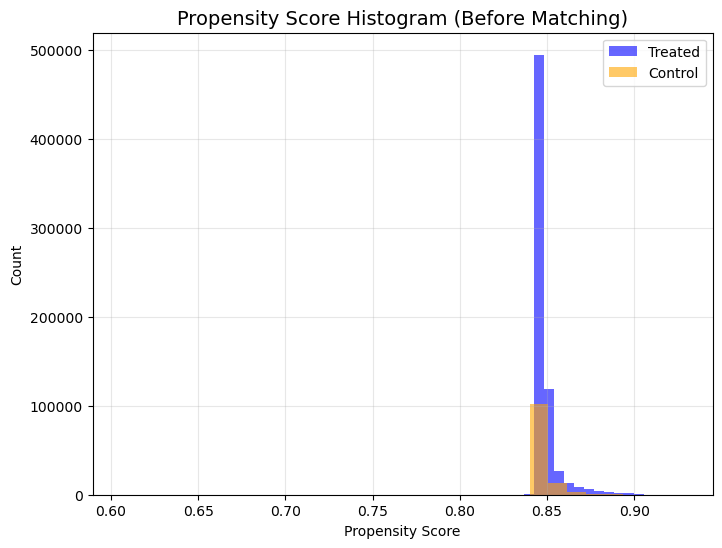

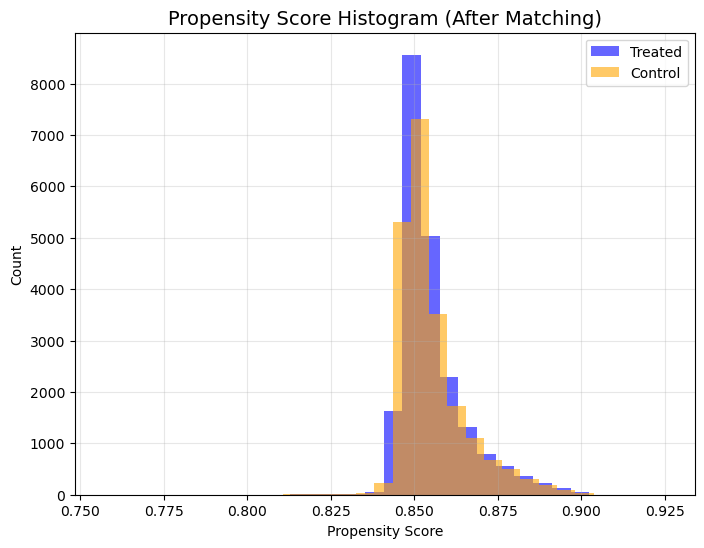

In [15]:
# Propensity score distribution
# Before matching, treated users usually have higher or lower propensity scores (bias).
# After PSM, both groups should overlap more — showing balance.

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Before Matching
plt.figure(figsize=(8,6))
plt.hist(train_df.loc[train_df['treatment']==1, 'propensity_score'], 
         bins=30, alpha=0.6, label='Treated', color='blue')
plt.hist(train_df.loc[train_df['treatment']==0, 'propensity_score'], 
         bins=30, alpha=0.6, label='Control', color='orange')

plt.title('Propensity Score Histogram (Before Matching)', fontsize=14)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# After Matching
plt.figure(figsize=(8,6))
plt.hist(matched_df.loc[matched_df['treatment']==1, 'propensity_score'], 
         bins=30, alpha=0.6, label='Treated', color='blue')
plt.hist(matched_df.loc[matched_df['treatment']==0, 'propensity_score'], 
         bins=30, alpha=0.6, label='Control', color='orange')

plt.title('Propensity Score Histogram (After Matching)', fontsize=14)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



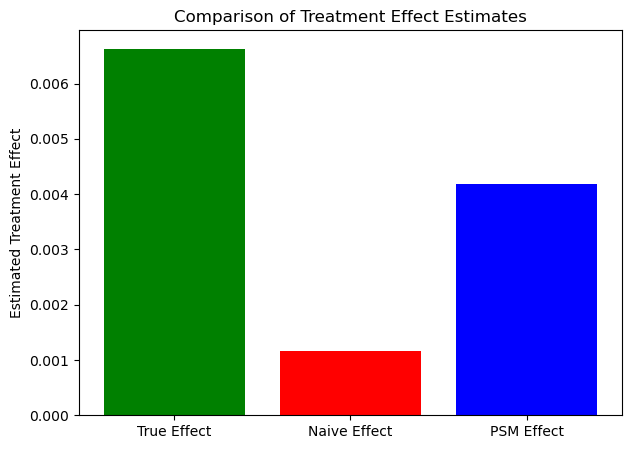

In [16]:
effects = {
    "True Effect": true_effect,
    "Naive Effect": naive_effect,
    "PSM Effect": psm_effect
}

plt.figure(figsize=(7,5))
plt.bar(effects.keys(), effects.values(), color=['green', 'red', 'blue'])
plt.ylabel("Estimated Treatment Effect")
plt.title("Comparison of Treatment Effect Estimates")
plt.show()

In [17]:
# Calculate metrics
true_uplift = true_effect
corrected_uplift = psm_effect
naive_uplift = naive_effect

error_naive = abs(true_uplift - naive_uplift)
error_psm = abs(true_uplift - corrected_uplift)

error_reduction = ((error_naive - error_psm) / error_naive) * 100

print("===== Summary Report =====")
print(f"True Uplift: {true_uplift:.6f}")
print(f"Naive Uplift: {naive_uplift:.6f}")
print(f"Corrected (PSM) Uplift: {corrected_uplift:.6f}")
print(f"Error Reduction: {error_reduction:.2f}%")


===== Summary Report =====
True Uplift: 0.006632
Naive Uplift: 0.001172
Corrected (PSM) Uplift: 0.004176
Error Reduction: 55.02%


<b>Now creating a uplift model that tells that what user we should send ad to increase outcome based on past info.
<br>As psm told us that the treatement give 0.41% increase in outcome. So we now make a actual ml model

In [18]:
# T-learner: train separate models for treated and control outcomes
model_treated=RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=42,max_depth=8)
model_control=RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=42,max_depth=8)

X_treated = train_df[train_df['treatment']==1][feature_col]
Y_treated = train_df[train_df['treatment']==1]['conversion']
X_control = train_df[train_df['treatment']==0][feature_col]
Y_control = train_df[train_df['treatment']==0]['conversion']

model_treated.fit(X_treated,Y_treated)
model_control.fit(X_control,Y_control)

X_test = test_df[feature_col].copy()
p_treated_test = model_treated.predict_proba(X_test)[:,1]
p_control_test = model_control.predict_proba(X_test)[:,1]

uplift_t_test = p_treated_test - p_control_test

In [19]:
#  S-learner: single model with treatment as a feature
X_train_s = train_df[feature_col + ['treatment']].copy()
y_train_s = train_df[outcome_col]

s_model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=999, n_jobs=-1)
s_model.fit(X_train_s, y_train_s)

# To estimate p(Y|T=1,X) and p(Y|T=0,X) with S-learner:
X_test_t1 = X_test.copy(); X_test_t1['treatment'] = 1
X_test_t0 = X_test.copy(); X_test_t0['treatment'] = 0

p_treated_test_s = s_model.predict_proba(X_test_t1)[:,1]
p_control_test_s = s_model.predict_proba(X_test_t0)[:,1]

uplift_s_test = p_treated_test_s - p_control_test_s

c:\Users\achin\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [20]:
import pandas as pd

def policy_performance(df, uplift_scores, treatment_col, outcome_col, top_pct=0.2):
    # Ensure uplift_scores is a Series aligned with df
    uplift_scores = pd.Series(uplift_scores, index=df.index, name="uplift_score")
    df = df.copy()
    df["uplift_score"] = uplift_scores

    # Number of users to target (top X%)
    n_target = int(len(df) * top_pct)

    # Get top uplift users
    top_idx = uplift_scores.nlargest(n_target).index

    # Simulate targeting
    treated_group = df.loc[top_idx]

    # Estimate incremental conversions (rough estimate)
    est_incremental_conv = treated_group["uplift_score"].mean() * n_target

    return {
        "n_target": n_target,
        "mean_uplift_target": treated_group["uplift_score"].mean(),
        "predicted_incremental_conversions": est_incremental_conv
    }

# Compare T-learner and S-learner uplift targeting
print("T-learner policy performance:",
      policy_performance(test_df, uplift_t_test, "treatment", "conversion", top_pct=0.2))

print("S-learner policy performance:",
      policy_performance(test_df, uplift_s_test, "treatment", "conversion", top_pct=0.2))


T-learner policy performance: {'n_target': 40000, 'mean_uplift_target': np.float64(0.0053778394049489395), 'predicted_incremental_conversions': np.float64(215.11357619795757)}
S-learner policy performance: {'n_target': 40000, 'mean_uplift_target': np.float64(0.0004902749263184212), 'predicted_incremental_conversions': np.float64(19.61099705273685)}


In [21]:
# Business parameters
value_per_conversion = 100   # revenue gained per conversion
cost_per_ad = 1              # cost to send one ad

# Expected profit for each user
expected_profit_per_user = uplift_t_test * value_per_conversion - cost_per_ad

# Choose only those where expected profit > 0
profitable_users = test_df.loc[expected_profit_per_user > 0]
print(f"Number of profitable users to target: {len(profitable_users)}")


Number of profitable users to target: 4677


In [22]:
import joblib
joblib.dump(model_treated, "uplift_t_model.pkl")
joblib.dump(model_control, "uplift_c_model.pkl")

['uplift_c_model.pkl']

In [27]:
import pandas as pd

# Keep all features numeric, matching training distribution
new_user = pd.DataFrame([[28, 5000, 3, 1, 0, 120, 0.4, 200, 0.2, 6, 1, 0]],
    columns=[f'f{i}' for i in range(12)]
)

model_treated=joblib.load('uplift_t_model.pkl')
model_control=joblib.load('uplift_c_model.pkl')
p_treat = model_treated.predict_proba(new_user)[0, 1]
p_control = model_control.predict_proba(new_user)[0, 1]
uplift = p_treat - p_control

print(f"Predicted uplift for new user: {uplift:.4f}")

Predicted uplift for new user: 0.0401


In [29]:
import pandas as pd
import joblib

# Load models
model_treated = joblib.load('uplift_t_model.pkl')
model_control = joblib.load('uplift_c_model.pkl')

# Define 10 test users
users_data = [
    [25, 3000, 1, 0.2, 50, -20, 0.7, 50, 0.1, 2, 0.5, -10],      # User 1: Low engagement
    [35, 6000, 5, 0.5, 100, 0, 0.4, 150, 0.3, 5, 0.7, 0],         # User 2: Medium engagement
    [50, 10000, 10, 0.9, 200, 50, 0.1, 300, 0.8, 10, 0.9, 20],   # User 3: High engagement
    [28, 8000, 2, 0.8, 180, 30, 0.2, 250, 0.6, 8, 0.8, 15],      # User 4: Young professional
    [40, 4000, 8, 0.1, 30, -50, 0.9, 40, 0.1, 1, 0.3, -20],      # User 5: High churn risk
    [45, 12000, 15, 0.95, 250, 80, 0.05, 400, 0.9, 15, 0.95, 30], # User 6: Very active
    [32, 5500, 4, 0.5, 120, 10, 0.5, 180, 0.5, 6, 0.6, 5],       # User 7: Average
    [38, 7000, 6, 0.4, 80, -30, 0.7, 100, 0.3, 3, 0.4, -15],     # User 8: Declining
    [27, 9000, 1, 0.7, 150, 60, 0.3, 220, 0.7, 9, 0.8, 25],      # User 9: High potential
    [55, 15000, 20, 0.2, 40, -40, 0.8, 60, 0.2, 2, 0.4, -10]     # User 10: Inactive
]

feature_cols = [f'f{i}' for i in range(12)]

# Create DataFrame
users_df = pd.DataFrame(users_data, columns=feature_cols)
users_df['user_id'] = [f'user_{i+1:03d}' for i in range(len(users_df))]

# Predict for all users
users_df['p_treated'] = model_treated.predict_proba(users_df[feature_cols])[:, 1]
users_df['p_control'] = model_control.predict_proba(users_df[feature_cols])[:, 1]
users_df['uplift'] = users_df['p_treated'] - users_df['p_control']

# Calculate expected profit
VALUE_PER_CONVERSION = 100
COST_PER_AD = 1
users_df['expected_profit'] = users_df['uplift'] * VALUE_PER_CONVERSION - COST_PER_AD

# Add decision
def get_decision(row):
    if row['expected_profit'] > 0 and row['uplift'] > 0.01:
        return 'Send Ad'
    elif row['uplift'] < -0.01:
        return 'Do NOT Send'
    else:
        return 'Neutral'

users_df['decision'] = users_df.apply(get_decision, axis=1)

# Display results
print("="*100)
print("UPLIFT PREDICTIONS FOR 10 TEST USERS")
print("="*100)
print(users_df[['user_id', 'p_treated', 'p_control', 'uplift', 'expected_profit', 'decision']].to_string(index=False))

print("\n" + "="*100)
print("SUMMARY")
print("="*100)
print(f"Total Users: {len(users_df)}")
print(f"Average Uplift: {users_df['uplift'].mean():.6f}")
print(f"Uplift Range: [{users_df['uplift'].min():.6f}, {users_df['uplift'].max():.6f}]")
print(f"Send Ad: {(users_df['decision'] == 'Send Ad').sum()} users")
print(f"Do NOT Send: {(users_df['decision'] == 'Do NOT Send').sum()} users")
print(f"Neutral: {(users_df['decision'] == 'Neutral').sum()} users")
print(f"Total Expected Profit: ${users_df['expected_profit'].sum():.2f}")

UPLIFT PREDICTIONS FOR 10 TEST USERS
 user_id  p_treated  p_control   uplift  expected_profit decision
user_001   0.334989   0.321780 0.013209         0.320872  Send Ad
user_002   0.259937   0.188602 0.071335         6.133513  Send Ad
user_003   0.205986   0.118121 0.087865         7.786507  Send Ad
user_004   0.220181   0.155811 0.064370         5.437007  Send Ad
user_005   0.329867   0.321752 0.008115        -0.188519  Neutral
user_006   0.206165   0.117038 0.089127         7.912716  Send Ad
user_007   0.227710   0.156227 0.071483         6.148343  Send Ad
user_008   0.324725   0.321752 0.002973        -0.702720  Neutral
user_009   0.220181   0.155811 0.064370         5.437007  Send Ad
user_010   0.351807   0.243168 0.108639         9.863875  Send Ad

SUMMARY
Total Users: 10
Average Uplift: 0.058149
Uplift Range: [0.002973, 0.108639]
Send Ad: 8 users
Do NOT Send: 0 users
Neutral: 2 users
Total Expected Profit: $48.15
